In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input,Dropout
import matplotlib.pyplot as plt
import datetime as dt
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

2024-08-02 10:37:54.875485: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-02 10:37:54.875592: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-02 10:37:54.984863: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


/kaggle/input/passenger/passenger.csv
/kaggle/input/second/keras/default/1/second.h5
/kaggle/input/passenger-scale/passenger_timescale_202407170947.csv


In [74]:
df = pd.read_csv("/kaggle/input/passenger-scale/passenger_timescale_202407170947.csv",parse_dates = ["bucket"])

In [75]:
df

,bucket,count
0,2024-02-23 21:50:11,PC-5309-20240223-ADB-CGN:140
1,2024-02-23 21:41:29,PC-5309-20240223-ADB-CGN:68
2,2024-02-23 21:31:55,PC-5309-20240223-ADB-CGN:139
3,2024-02-23 21:29:15,PC-5309-20240223-ADB-CGN:23
4,2024-02-23 21:28:12,PC-5309-20240223-ADB-CGN:138
...,...,...
1826455,2022-11-25 03:44:29,PC-1860-20221125-ADB-ECN:28
1826456,2022-11-25 03:38:25,PC-1860-20221125-ADB-ECN:7
1826457,2022-11-25 03:38:22,PC-1860-20221125-ADB-ECN:6
1826458,2022-11-25 03:37:37,PC-1860-20221125-ADB-ECN:27


In [76]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1826460 entries, 0 to 1826459
Data columns (total 2 columns):
 #   Column  Dtype         
---  ------  -----         
 0   bucket  datetime64[ns]
 1   count   object        
dtypes: datetime64[ns](1), object(1)
memory usage: 27.9+ MB


In [61]:
df.describe()

,bucket
count,1826460
mean,2023-07-22 11:25:14.491708672
min,2022-11-25 03:37:34
25%,2023-05-18 12:00:15.750000128
50%,2023-07-27 23:54:48.500000
75%,2023-09-26 20:41:09.750000128
max,2024-02-23 21:50:11


In [77]:
extracted = df['count'].str.extract(r'(\w+-\d+)-(\d+)-(\w+)-(\w+):(\d+)')

In [78]:
extracted[4].isnull().sum()

1558

In [79]:
extracted= extracted.dropna()

In [31]:
#extracted["flight_no"] = extracted[0]
#extracted["flight_date"] = extracted[1]
#extracted["departure"] = extracted[2]
#extracted["arrival"] =extracted[3]
#extracted["count"] =extracted[4]

In [80]:
extracted = extracted.rename(columns = {0:"flight_no",1:"flight_date",2:"departure",3:"arrival",4:"count"})

In [81]:
extracted["checkin_time"] = df['bucket']

In [82]:
extracted = extracted.sort_values("checkin_time")

In [83]:
extracted = extracted[["count","checkin_time"]]

Text(0, 0.5, 'Passenger Count')

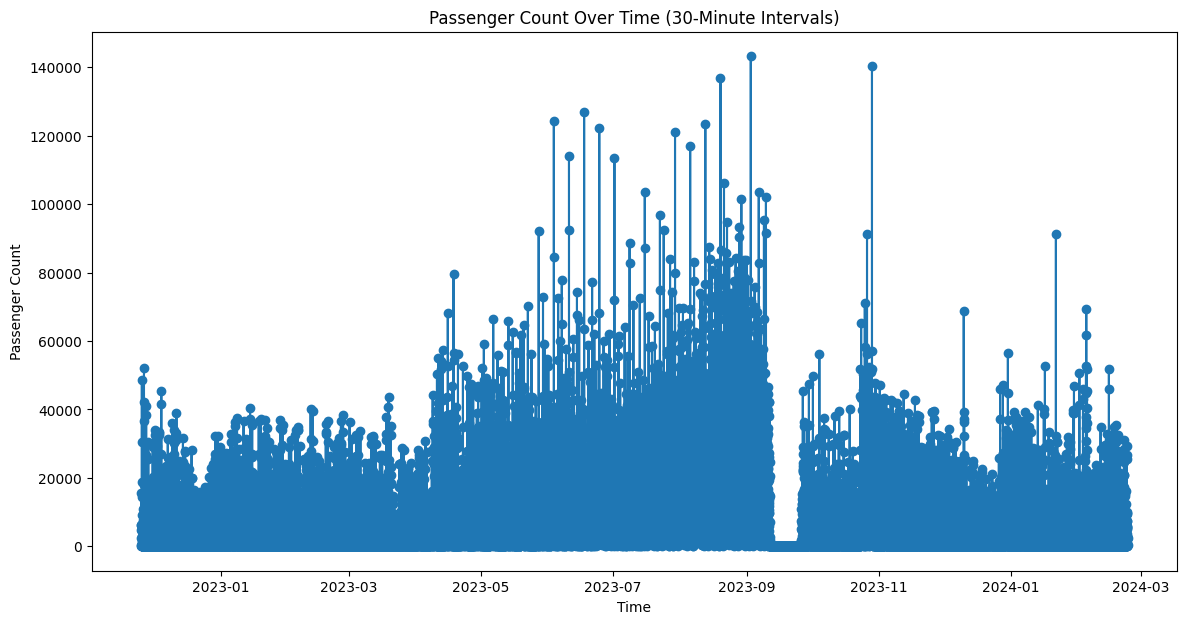

In [19]:
extracted['count'] = extracted['count'].astype(int)
sorted_extract = extracted.sort_values(by='checkin_time')

# Resample the data to 30-minute intervals, summing the passenger count
resampled_data = sorted_extract.set_index('checkin_time').resample('30min')['count'].sum().reset_index()

# Visualize the resampled data
plt.figure(figsize=(14, 7))
plt.plot(resampled_data['checkin_time'], resampled_data['count'], marker='o', linestyle='-')
plt.title('Passenger Count Over Time (30-Minute Intervals)')
plt.xlabel('Time')
plt.ylabel('Passenger Count')

In [20]:
#resaambled data is now model data that we have to create
time_series_data = resampled_data['count'].values

In [69]:
resampled_data

,checkin_time,count,checkin_time_30min_before
0,2022-11-25 03:30:00,218,2022-11-25 03:00:00
1,2022-11-25 04:00:00,2361,2022-11-25 03:30:00
2,2022-11-25 04:30:00,15463,2022-11-25 04:00:00
3,2022-11-25 05:00:00,6227,2022-11-25 04:30:00
4,2022-11-25 05:30:00,6205,2022-11-25 05:00:00
...,...,...,...
21872,2024-02-23 19:30:00,7289,2024-02-23 19:00:00
21873,2024-02-23 20:00:00,5821,2024-02-23 19:30:00
21874,2024-02-23 20:30:00,5757,2024-02-23 20:00:00
21875,2024-02-23 21:00:00,2265,2024-02-23 20:30:00


In [27]:
scaler = MinMaxScaler(feature_range=(0, 1))
count_scaled = scaler.fit_transform(time_series_data.reshape(-1, 1))

# Girdi ve çıktılar için zaman adımları belirleyelim
n_lookback = 60  # giriş sekansı uzunluğu (geçmiş dönemi)
n_forecast = 60  # tahmin sekansı uzunluğu (gelecek dönemi)

# Giriş ve çıkış sekanslarını oluştur
X = []
Y = []

for i in range(n_lookback, len(count_scaled) - n_forecast + 1):
    X.append(count_scaled[i - n_lookback: i])
    Y.append(count_scaled[i: i + n_forecast])

X = np.array(X)
Y = np.array(Y)
X = np.reshape(X, (X.shape[0], n_lookback, 1))

# LSTM Modeli Oluşturma
model2 = Sequential()
model2.add(LSTM(units=50, return_sequences=True, input_shape=(n_lookback, 1)))
model2.add(LSTM(units=50))
model2.add(Dense(n_forecast))

model2.compile(loss='mean_squared_error', optimizer='adam')
model2.fit(X, Y, epochs=10, batch_size=32, verbose=1)

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


680/680 ━━━━━━━━━━━━━━━━━━━━ 27s 36ms/step - loss: 0.0059
Epoch 2/10
680/680 ━━━━━━━━━━━━━━━━━━━━ 25s 36ms/step - loss: 0.0050
Epoch 3/10
680/680 ━━━━━━━━━━━━━━━━━━━━ 25s 36ms/step - loss: 0.0046
Epoch 4/10
680/680 ━━━━━━━━━━━━━━━━━━━━ 25s 36ms/step - loss: 0.0042
Epoch 5/10
680/680 ━━━━━━━━━━━━━━━━━━━━ 25s 36ms/step - loss: 0.0040
Epoch 6/10
680/680 ━━━━━━━━━━━━━━━━━━━━ 25s 36ms/step - loss: 0.0037
Epoch 7/10
680/680 ━━━━━━━━━━━━━━━━━━━━ 24s 36ms/step - loss: 0.0036
Epoch 8/10
680/680 ━━━━━━━━━━━━━━━━━━━━ 25s 36ms/step - loss: 0.0034
Epoch 9/10
680/680 ━━━━━━━━━━━━━━━━━━━━ 25s 36ms/step - loss: 0.0033
Epoch 10/10
680/680 ━━━━━━━━━━━━━━━━━━━━ 25s 36ms/step - loss: 0.0032


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step


/tmp/ipykernel_33/550713265.py:10: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_future['Date'] = pd.date_range(start=df_past['Date'].iloc[-1] + pd.Timedelta(hours=1), periods=n_forecast, freq='H')


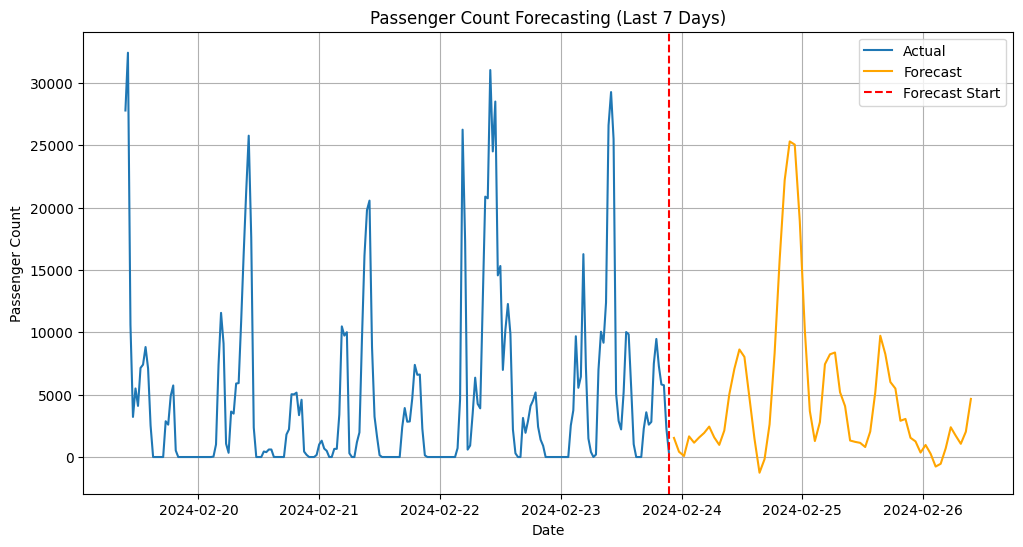

In [28]:
X_ = count_scaled[-n_lookback:]
X_ = X_.reshape(1, n_lookback, 1)

Y_ = model2.predict(X_).reshape(-1, 1)
Y_ = scaler.inverse_transform(Y_)

# Sonuçları organize etme
df_past = resampled_data.rename(columns={'checkin_time': 'Date', 'count': 'Actual'})
df_future = pd.DataFrame(columns=['Date', 'Actual', 'Forecast'])
df_future['Date'] = pd.date_range(start=df_past['Date'].iloc[-1] + pd.Timedelta(hours=1), periods=n_forecast, freq='H')
df_future['Forecast'] = Y_.flatten()

# Geçmiş verileri ve tahminleri birleştirme
df_results = pd.concat([df_past, df_future], ignore_index=True)

# Grafiği belirli bir tarih aralığında gösterme (son 7 gün)
end_date = df_results['Date'].max()
start_date = end_date - pd.Timedelta(days=7)
df_zoomed = df_results[(df_results['Date'] >= start_date) & (df_results['Date'] <= end_date)]

# Sonuçları görselleştirme
plt.figure(figsize=(12, 6))
plt.plot(df_zoomed['Date'], df_zoomed['Actual'], label='Actual')
plt.plot(df_zoomed['Date'], df_zoomed['Forecast'], label='Forecast', color='orange')
plt.axvline(x=df_past['Date'].iloc[-1], color='r', linestyle='--', label='Forecast Start')
plt.xlabel('Date')
plt.ylabel('Passenger Count')
plt.title('Passenger Count Forecasting (Last 7 Days)')
plt.legend()
plt.grid(True)
plt.show()

In [24]:
model2.save('model2.h5')

In [ ]:
extracted.flight_date

In [ ]:
#extracted['hour'] = df['checkin_time'].dt.hour
#extracted['minute'] = df['checkin_time'].dt.minute
#extracted['second'] = df['checkin_time'].dt.second

In [21]:
extracted

,flight_no,flight_date,departure,arrival,count,checkin_time
0,PC-5309,20240223,ADB,CGN,140,2024-02-23 21:50:11
1,PC-5309,20240223,ADB,CGN,68,2024-02-23 21:41:29
2,PC-5309,20240223,ADB,CGN,139,2024-02-23 21:31:55
3,PC-5309,20240223,ADB,CGN,23,2024-02-23 21:29:15
4,PC-5309,20240223,ADB,CGN,138,2024-02-23 21:28:12
...,...,...,...,...,...,...
1826455,PC-1860,20221125,ADB,ECN,28,2022-11-25 03:44:29
1826456,PC-1860,20221125,ADB,ECN,7,2022-11-25 03:38:25
1826457,PC-1860,20221125,ADB,ECN,6,2022-11-25 03:38:22
1826458,PC-1860,20221125,ADB,ECN,27,2022-11-25 03:37:37


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1826460 entries, 0 to 1826459
Data columns (total 2 columns):
 #   Column  Dtype         
---  ------  -----         
 0   bucket  datetime64[ns]
 1   count   object        
dtypes: datetime64[ns](1), object(1)
memory usage: 27.9+ MB


In [81]:
resampled_data

,checkin_time,count
0,2022-11-25 03:30:00,218
1,2022-11-25 04:00:00,2361
2,2022-11-25 04:30:00,15463
3,2022-11-25 05:00:00,6227
4,2022-11-25 05:30:00,6205
...,...,...
21872,2024-02-23 19:30:00,7289
21873,2024-02-23 20:00:00,5821
21874,2024-02-23 20:30:00,5757
21875,2024-02-23 21:00:00,2265


In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

scaler = MinMaxScaler(feature_range=(0, 1))
time_series_data_scaled = scaler.fit_transform(time_series_data.reshape(-1, 1))

def create_dataset(time_series_data_scaled, time_step=1):
    X, Y = [], []
    for i in range(len(time_series_data_scaled)-time_step-1):
        X.append(time_series_data_scaled[i:(i+time_step), 0])
        Y.append(time_series_data_scaled[i + time_step, 0])
    return np.array(X), np.array(Y)

time_step = 50
X, Y = create_dataset(time_series_data_scaled, time_step)

# Veriyi LSTM modeline uygun hale getirme 
X = np.reshape(X, (X.shape[0], time_step, 1))

In [14]:
time_step = 50
generator = TimeseriesGenerator(time_series_data_scaled, time_series_data_scaled,
                                length=time_step, batch_size=1)

# Veri ve etiketleri alma
X, Y = [], []
for i in range(len(generator)):
    x, y = generator[i]
    X.append(x)
    Y.append(y)

X = np.array(X).reshape(-1, time_step, 1)
Y = np.array(Y).reshape(-1, 1)

print("Şekil:", X.shape, Y.shape)

Şekil: (21827, 50, 1) (21827, 1)


In [88]:
X.shape,Y.shape

((21827, 50, 1), (21827, 1))

In [15]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(time_step, 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

# Modeli derleme
model.compile(optimizer='adam', loss='mean_squared_error')

# Modeli eğitme
model.fit(X, Y, epochs=10, batch_size=32)

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


683/683 ━━━━━━━━━━━━━━━━━━━━ 24s 31ms/step - loss: 0.0053
Epoch 2/10
683/683 ━━━━━━━━━━━━━━━━━━━━ 41s 31ms/step - loss: 0.0030
Epoch 3/10
683/683 ━━━━━━━━━━━━━━━━━━━━ 22s 31ms/step - loss: 0.0028
Epoch 4/10
683/683 ━━━━━━━━━━━━━━━━━━━━ 22s 32ms/step - loss: 0.0028
Epoch 5/10
683/683 ━━━━━━━━━━━━━━━━━━━━ 22s 32ms/step - loss: 0.0027
Epoch 6/10
683/683 ━━━━━━━━━━━━━━━━━━━━ 21s 31ms/step - loss: 0.0031
Epoch 7/10
683/683 ━━━━━━━━━━━━━━━━━━━━ 21s 31ms/step - loss: 0.0026
Epoch 8/10
683/683 ━━━━━━━━━━━━━━━━━━━━ 21s 31ms/step - loss: 0.0027
Epoch 9/10
683/683 ━━━━━━━━━━━━━━━━━━━━ 41s 31ms/step - loss: 0.0028
Epoch 10/10
683/683 ━━━━━━━━━━━━━━━━━━━━ 21s 31ms/step - loss: 0.0026


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━

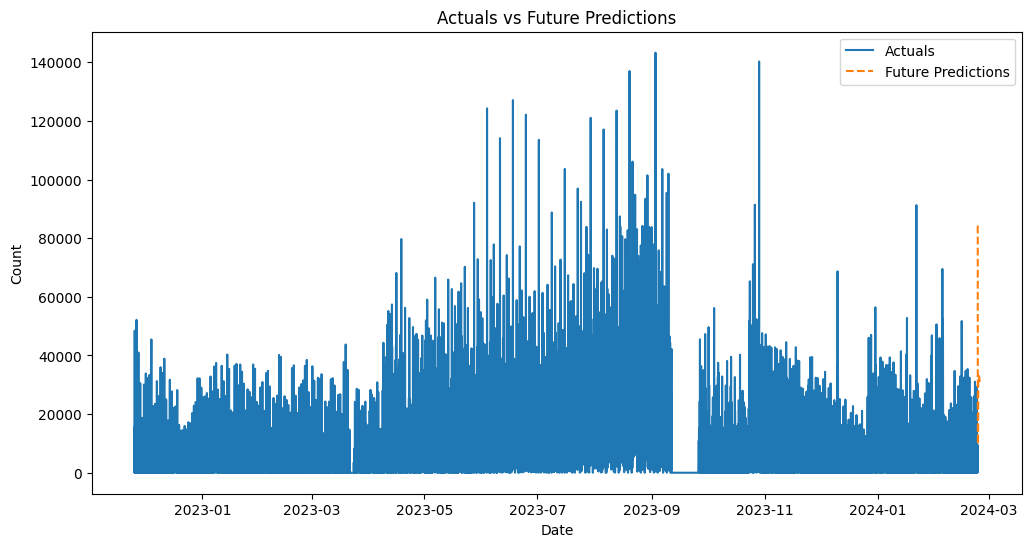

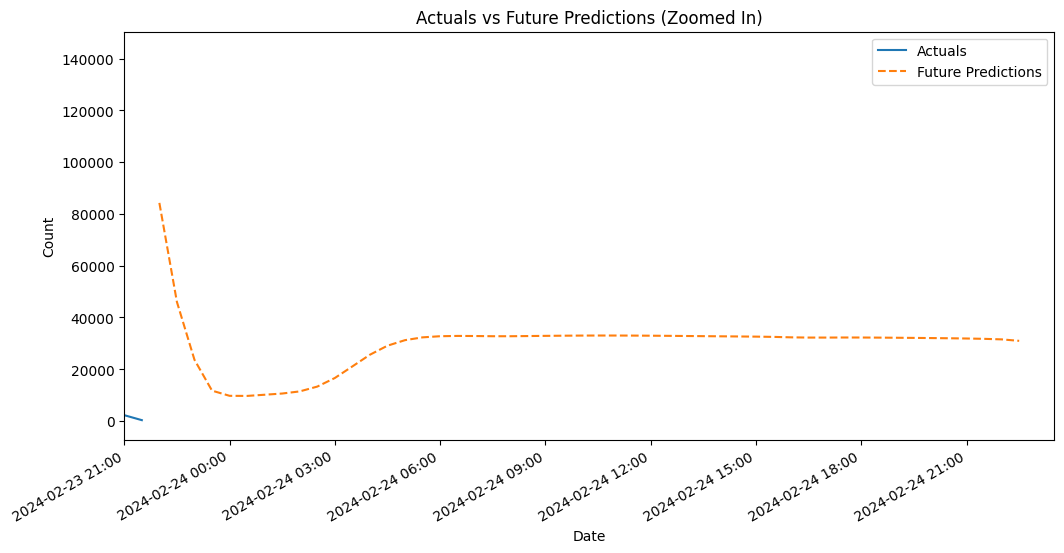

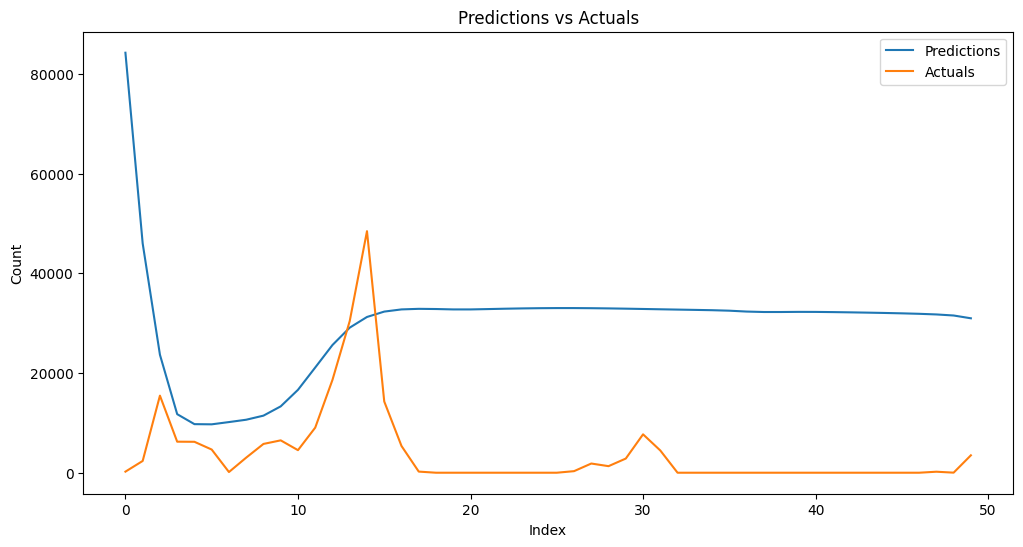

In [29]:
from matplotlib.dates import DateFormatter

# Gelecekteki tahminleri yapmak için veri hazırlama
last_sequence = time_series_data[-time_step:]
last_sequence = last_sequence.reshape((1, time_step, 1))

future_steps = 50
predictions = []

for _ in range(future_steps):
    prediction = model.predict(last_sequence)
    predictions.append(prediction[0, 0])
    last_sequence = np.concatenate((last_sequence[:, 1:, :], np.reshape(prediction, (1, 1, 1))), axis=1)

# Tahminleri ters normalizasyon
predictions = np.array(predictions).reshape(-1, 1)
predictions = scaler.inverse_transform(predictions)

# Negatif tahminleri sıfıra ayarla
predictions[predictions < 0] = 0

# Grafik oluşturma
future_dates = pd.date_range(start=resampled_data['checkin_time'].iloc[-1] + pd.Timedelta(minutes=30), periods=future_steps, freq='30min')
future_df = pd.DataFrame(data={'Predictions': predictions.flatten()}, index=future_dates)

plt.figure(figsize=(12, 6))
plt.plot(resampled_data['checkin_time'], resampled_data['count'], label='Actuals')
plt.plot(future_df.index, future_df['Predictions'], label='Future Predictions', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Actuals vs Future Predictions')
plt.legend()
plt.show()

# Grafik üzerinde tahmin edilen kısmı yakınlaştırma
plt.figure(figsize=(12, 6))
plt.plot(resampled_data['checkin_time'], resampled_data['count'], label='Actuals')
plt.plot(future_df.index, future_df['Predictions'], label='Future Predictions', linestyle='--')

# Tarih formatlaması
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Actuals vs Future Predictions (Zoomed In)')
plt.legend()

# Tarih formatını ayarlama
date_form = DateFormatter('%Y-%m-%d %H:%M')
plt.gca().xaxis.set_major_formatter(date_form)
plt.gcf().autofmt_xdate()

# Yakınlaştırma ayarları
plt.xlim([future_df.index[0] - pd.Timedelta(hours=1), future_df.index[-1] + pd.Timedelta(hours=1)])

plt.show()

# Tahminler ve gerçekteki verileri indeksleyerek karşılaştırma grafiği
start = 0
end = len(future_df)

indices = np.arange(start, end)
df = pd.DataFrame({
    'Predictions': predictions[start:end].flatten(),
    'Actuals': resampled_data['count'].values[start:end] if end < len(resampled_data) else np.nan
}, index=indices)

plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Predictions'], label='Predictions')
plt.plot(df.index, df['Actuals'], label='Actuals')
plt.xlabel('Index')
plt.ylabel('Count')
plt.title('Predictions vs Actuals')
plt.legend()
plt.show()

In [38]:
predicted = model2.predict(X)
# Gerçek ve tahmin edilen değerleri saklamak için yeni bir DataFrame oluşturma
results = pd.DataFrame({'Actual': Y.reshape(-1), 'Predicted': predicted.reshape(-1)})

680/680 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step


680/680 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step


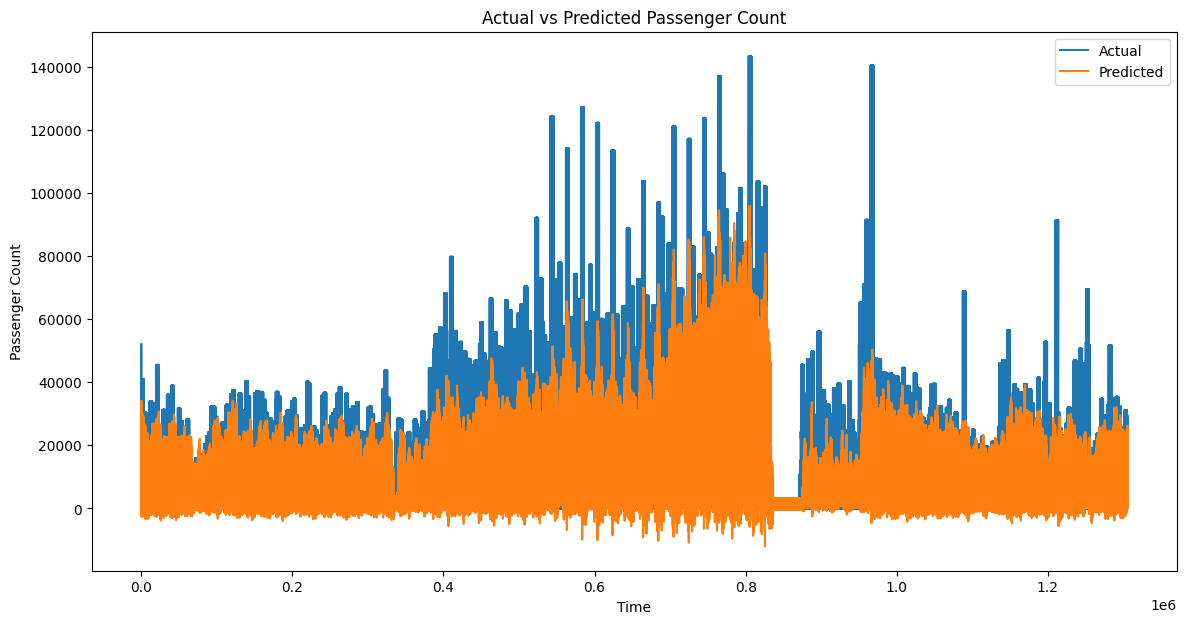

In [40]:
predicted = model2.predict(X)
predicted_values = scaler.inverse_transform(predicted.reshape(-1, 1))
actual_values = scaler.inverse_transform(Y.reshape(-1, 1))
# Tahminler ve gerçek değerleri görselleştirme
plt.figure(figsize=(14, 7))
plt.plot(actual_values, label='Actual')
plt.plot(predicted_values, label='Predicted')
plt.title('Actual vs Predicted Passenger Count')
plt.xlabel('Time')
plt.ylabel('Passenger Count')
plt.legend()
plt.show()

In [ ]:
y_true = results['Actual']
y_pred = results['Predicted']
accuracy= (y_pred)/(y_true + y_pred)*100

In [ ]:
print(f"{accuracy.mean()}")

In [ ]:
resampled_data.shape

In [35]:
y_true = results['Actual']
y_pred = results['Predicted']
# 30 dakika önceki zamanları hesaplayalım
resampled_data['checkin_time'] = pd.to_datetime(resampled_data['checkin_time'])
resampled_data['checkin_time_30min_before'] = resampled_data['checkin_time'] - pd.Timedelta(minutes=30)

# Gerçek ve tahmin edilen değerleri 30 dakika önceki zamanlara göre ayıralım
results['checkin_time'] = resampled_data['checkin_time']
results['checkin_time_30min_before'] = resampled_data['checkin_time_30min_before']

# 30 dakika önceki değerleri alalım
results_before_30min = results[results['checkin_time'].isin(results['checkin_time_30min_before'])]

print(results_before_30min)

           Actual  Predicted        checkin_time checkin_time_30min_before
0        0.255422   0.146753 2022-11-25 03:30:00       2022-11-25 03:00:00
1        0.363912   0.163046 2022-11-25 04:00:00       2022-11-25 03:30:00
2        0.293633   0.147433 2022-11-25 04:30:00       2022-11-25 04:00:00
3        0.016237   0.108337 2022-11-25 05:00:00       2022-11-25 04:30:00
4        0.000000   0.062863 2022-11-25 05:30:00       2022-11-25 05:00:00
...           ...        ...                 ...                       ...
1305475  0.050881   0.051980                 NaT                       NaT
1305476  0.040633   0.047120                 NaT                       NaT
1305477  0.040187   0.025104                 NaT                       NaT
1305478  0.015811   0.018889                 NaT                       NaT
1305479  0.002422   0.015863                 NaT                       NaT

[1305479 rows x 4 columns]


In [ ]:
results_before_30min = results_before_30min.sort_values(ascending=False,by="checkin_time_30min_before")

In [31]:
df = results_before_30min.copy()
df['Actual'] = df['Actual'].astype(float)
df['Predicted'] = df['Predicted'].astype(float)

In [32]:
df['checkin_time'] = df['checkin_time'].dt.strftime('%Y-%m-%d %H:%M:%S')
df['checkin_time_30min_before'] = df['checkin_time_30min_before'].dt.strftime('%Y-%m-%d %H:%M:%S')
checkin_times = df['checkin_time'].tolist()
checkin_times_30min_befores = df['checkin_time_30min_before'].tolist()
actuals = df['Actual'].tolist()
predicteds = df['Predicted'].tolist()

In [33]:
df

,Actual,Predicted,checkin_time,checkin_time_30min_before
21825,0.015811,0.044236,2024-02-22 20:00:00,2024-02-22 19:30:00
21824,0.040187,0.043711,2024-02-22 19:30:00,2024-02-22 19:00:00
21823,0.040633,0.050165,2024-02-22 19:00:00,2024-02-22 18:30:00
21822,0.050881,0.069071,2024-02-22 18:30:00,2024-02-22 18:00:00
21821,0.066098,0.071835,2024-02-22 18:00:00,2024-02-22 17:30:00
...,...,...,...,...
4,0.053603,0.046904,2022-11-25 05:30:00,2022-11-25 05:00:00
3,0.063278,0.054012,2022-11-25 05:00:00,2022-11-25 04:30:00
2,0.068890,0.035384,2022-11-25 04:30:00,2022-11-25 04:00:00
1,0.060332,0.065704,2022-11-25 04:00:00,2022-11-25 03:30:00


In [34]:
model.save('flight_model.h5')

In [35]:
!pip install pymilvus

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 MB 19.8 MB/s eta 0:00:0000:0100:01m


In [ ]:
#df = df.drop("flight_date",axis=1)

In [84]:
extracted["count"] = extracted["count"].astype(int)

In [37]:
extracted = extracted[["checkin_time","count"]]

In [85]:
extracted = extracted.set_index("checkin_time")

In [39]:
extracted = extracted.groupby('checkin_time').agg({'count': 'sum'}).reset_index()

In [40]:
# Check for missing values
print(extracted.isnull().sum())

# Summary statistics
print(extracted.describe())

checkin_time    0
count           0
dtype: int64
                        checkin_time         count
count                        1728949  1.728949e+06
mean   2023-07-22 06:27:19.499959808  1.071673e+02
min              2022-11-25 03:37:34  1.000000e+00
25%              2023-05-17 09:30:42  4.400000e+01
50%              2023-07-27 11:21:27  8.800000e+01
75%              2023-09-28 18:33:51  1.350000e+02
max              2024-02-23 21:50:11  9.999000e+03
std                              NaN  1.142079e+02


In [43]:
#hourly_counts = extracted.groupby('hour')['count'].sum().reset_index()

# Example: Aggregating counts by minute
#minute_counts = extracted.groupby(['hour', 'minute'])['count'].sum().reset_index()

KeyError: 'hour'

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


<Axes: ylabel='Count'>

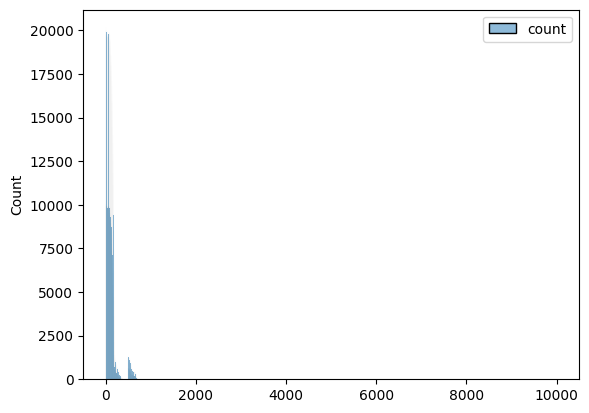

In [44]:
sns.histplot(extracted)

In [ ]:
#resampled_data = extracted.set_index('checkin_time').resample('30min')['count'].sum().reset_index()

In [45]:
#extracted = extracted.set_index("checkin_time")

In [26]:
#scaler = MinMaxScaler(feature_range=(0, 1))
#time_series_data_scaled = scaler.fit_transform(extracted['count'].values.reshape(-1, 1))

In [29]:
extracted

,flight_no,flight_date,departure,arrival,count,checkin_time
0,PC-5309,20240223,ADB,CGN,140,2024-02-23 21:50:11
1,PC-5309,20240223,ADB,CGN,68,2024-02-23 21:41:29
2,PC-5309,20240223,ADB,CGN,139,2024-02-23 21:31:55
3,PC-5309,20240223,ADB,CGN,23,2024-02-23 21:29:15
4,PC-5309,20240223,ADB,CGN,138,2024-02-23 21:28:12
...,...,...,...,...,...,...
1826455,PC-1860,20221125,ADB,ECN,28,2022-11-25 03:44:29
1826456,PC-1860,20221125,ADB,ECN,7,2022-11-25 03:38:25
1826457,PC-1860,20221125,ADB,ECN,6,2022-11-25 03:38:22
1826458,PC-1860,20221125,ADB,ECN,27,2022-11-25 03:37:37


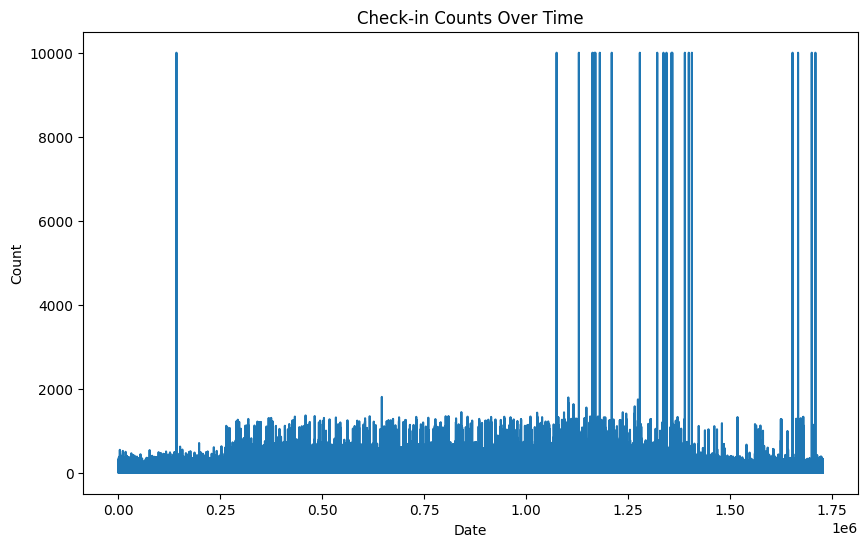

In [46]:
plt.figure(figsize=(10, 6))
plt.plot(extracted['count'])
plt.title('Check-in Counts Over Time')
plt.xlabel('Date')
plt.ylabel('Count')
plt.show()

Outliers:
                checkin_time  count
161     2022-11-25 04:50:13    273
511     2022-11-25 08:30:50    328
1042    2022-11-25 10:15:34    280
1043    2022-11-25 10:15:37    278
1047    2022-11-25 10:16:11    274
...                     ...    ...
1727536 2024-02-23 10:17:07    287
1727768 2024-02-23 10:41:35    311
1727819 2024-02-23 10:46:40    336
1727901 2024-02-23 11:01:35    333
1728293 2024-02-23 13:50:58    308

[75435 rows x 2 columns]


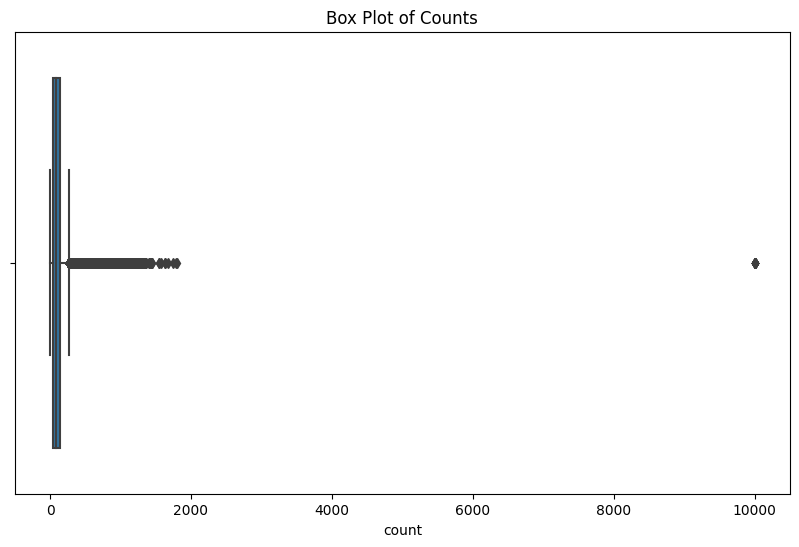

DataFrame after removing outliers:
                checkin_time  count
0       2022-11-25 03:37:34     26
1       2022-11-25 03:37:37     27
2       2022-11-25 03:38:22      6
3       2022-11-25 03:38:25      7
4       2022-11-25 03:44:29     28
...                     ...    ...
1728944 2024-02-23 21:28:12    138
1728945 2024-02-23 21:29:15     23
1728946 2024-02-23 21:31:55    139
1728947 2024-02-23 21:41:29     68
1728948 2024-02-23 21:50:11    140

[1653514 rows x 2 columns]


In [47]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'extracted' is your DataFrame
# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = extracted['count'].quantile(0.25)
Q3 = extracted['count'].quantile(0.75)

# Calculate IQR (Interquartile Range)
IQR = Q3 - Q1

# Define outlier bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers = extracted[(extracted['count'] < lower_bound) | (extracted['count'] > upper_bound)]
print("Outliers:\n", outliers)

# Visualize outliers using a box plot
plt.figure(figsize=(10, 6))
sns.boxplot(x=extracted['count'])
plt.title('Box Plot of Counts')
plt.show()

# Remove outliers
cleaned_extracted = extracted[(extracted['count'] >= lower_bound) & (extracted['count'] <= upper_bound)]

# Verify the removal
print("DataFrame after removing outliers:\n", cleaned_extracted)
extracted = extracted[(extracted['count'] >= lower_bound) & (extracted['count'] <= upper_bound)]


In [32]:
model1.save("second.h5")

In [48]:
#from sklearn.metrics import mean_squared_error

#mse = mean_squared_error(actual_values, predicted_values)
#print("Mean Squared Error:", mse)

In [ ]:
from pymilvus import connections, FieldSchema, CollectionSchema, DataType, Collection

# Milvus'a bağlanma
connections.connect(host='127.0.0.1', port='19530')

# Alan şemalarını tanımlama
fields = [
    FieldSchema(name="ID", dtype=DataType.INT64, is_primary=True),
    FieldSchema(name="timestamp", dtype=DataType.FLOAT),
    FieldSchema(name="actual_value", dtype=DataType.FLOAT),
    FieldSchema(name="predicted_value", dtype=DataType.FLOAT),
    FieldSchema(name="vector", dtype=DataType.FLOAT_VECTOR, dim=128)  # Örnek vektör boyutu 128
]

# Koleksiyon şemasını oluşturma
schema = CollectionSchema(fields, description="Zaman serisi tahmin verileri")

# Koleksiyon oluşturma
collection = Collection(name="time_series_collection", schema=schema)

# Vektör verilerini örnekleme (örnek olarak rastgele veriler kullanılıyor)

ids = [i for i in range(100)]
timestamps = np.random.random(100).tolist()
vectors = np.random.random((100, 128)).tolist()  # Örnek vektör verisi

# Veriyi Milvus'a ekleme
entities = [ids, timestamps, actual_values, predicted_values, vectors]
collection.insert(entities)


In [51]:
#import pymilvus

#collection.load()
#query = {"bool": {"must": []}}
#results = collection.query(query)
#for result in results:
#    print(result)


MilvusException: <MilvusException: (code=700, message=index not found[collection=time_series_collection])>

In [14]:
!pip install pystan

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 MB 27.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 49.6 MB/s eta 0:00:00:00:01


In [86]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

In [87]:
def df_to_X_y(df, window_size=5):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np)-window_size):
        row = [[a] for a in df_as_np[i:i+window_size]]
        X.append(row)
        label = df_as_np[i+window_size]
        y.append(label)
    return np.array(X), np.array(y)
WINDOW_SIZE = 5
X1, y1 = df_to_X_y(extracted, WINDOW_SIZE)
X1.shape, y1.shape

((1824897, 5, 1, 1), (1824897, 1))

In [88]:
X_train1, y_train1 = X1[:200000], y1[:200000]
X_val1, y_val1 = X1[200000:240000], y1[200000:240000]
X_test1, y_test1 = X1[240000:], y1[240000:]
X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, X_test1.shape, y_test1.shape

((200000, 5, 1, 1),
 (200000, 1),
 (40000, 5, 1, 1),
 (40000, 1),
 (1584897, 5, 1, 1),
 (1584897, 1))

In [89]:
# Modeli oluşturma
model1 = Sequential()
model1.add(InputLayer((5,1)))
model1.add(LSTM(64))
model1.add(Dense(8, activation='relu'))
model1.add(Dense(1, activation='linear'))

# Modelin özetini görüntüleme
model1.summary()

# Modeli derleme
model1.compile(optimizer=Adam(learning_rate=0.001), 
               loss=MeanSquaredError(), 
               metrics=[RootMeanSquaredError()])

# Modeli eğitme
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, mode='min')

history = model1.fit(X_train1, y_train1, 
                     validation_data=(X_val1, y_val1), 
                     epochs=50, 
                     callbacks=[checkpoint],
                     batch_size=64)

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_11 (LSTM)                  │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,425 (68.07 KB)

 Trainable params: 17,425 (68.07 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - loss: 4892.5063 - root_mean_squared_error: 68.5894 - val_loss: 1980.7070 - val_root_mean_squared_error: 44.5051
Epoch 2/50
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 2104.8765 - root_mean_squared_error: 45.7968 - val_loss: 1946.9790 - val_root_mean_squared_error: 44.1246
Epoch 3/50
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 2625.8372 - root_mean_squared_error: 50.9867 - val_loss: 1934.2344 - val_root_mean_squared_error: 43.9799
Epoch 4/50
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 2525.7815 - root_mean_squared_error: 50.0392 - val_loss: 1927.4414 - val_root_mean_squared_error: 43.9026
Epoch 5/50
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 2148.9390 - root_mean_squared_error: 46.2472 - val_loss: 1957.9580 - val_root_mean_squared_error: 44.2488
Epoch 6/50
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 1948.4929 - root_mean_squared_error: 44.1207 - val_loss: 1989.0166 - val_root_mean_squared_e

In [53]:
extracted = extracted.reset_index()
extracted = extracted.drop("index",axis = 1)

57029/57029 ━━━━━━━━━━━━━━━━━━━━ 100s 2ms/step


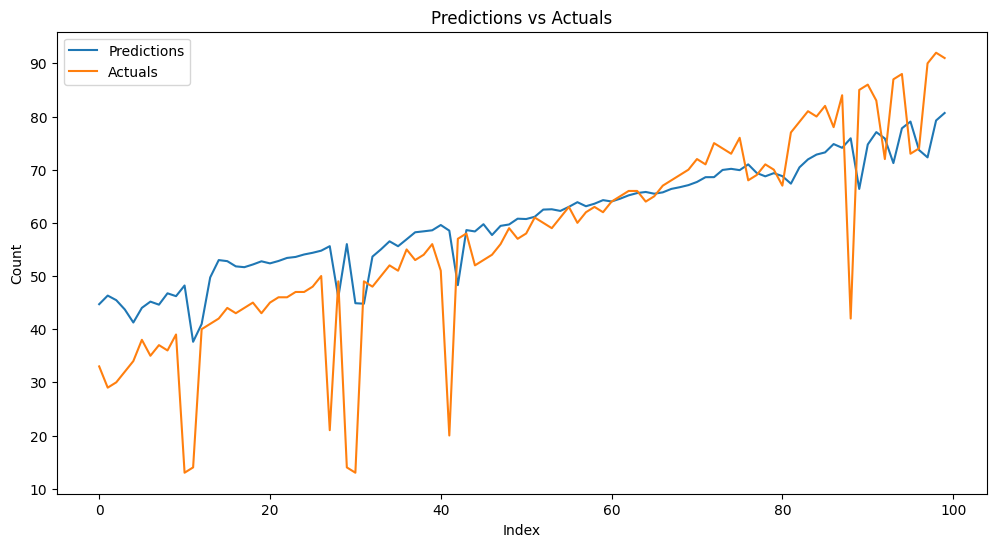

In [90]:
def plot_predictions(model, X, y, start=0, end=100):
    # Tahminleri yap
    predictions = model.predict(X)
    
    # Düzleştirme
    if len(predictions.shape) > 1:
        predictions = predictions.flatten()
    if len(y.shape) > 1:
        y = y.flatten()

    # İndeks oluşturma
    indices = np.arange(start, end)

    # Veri çerçevesini oluştur
    df = pd.DataFrame({
        'Predictions': predictions[start:end],
        'Actuals': y[start:end]
    }, index=indices)

    # Grafiği oluştur
    plt.figure(figsize=(12, 6))
    plt.plot(df.index, df['Predictions'], label='Predictions')
    plt.plot(df.index, df['Actuals'], label='Actuals')
    plt.xlabel('Index')
    plt.ylabel('Count')
    plt.title('Predictions vs Actuals')
    plt.legend()
    plt.show()

# Örnek kullanımı
plot_predictions(model1, X1, y1)

683/683 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


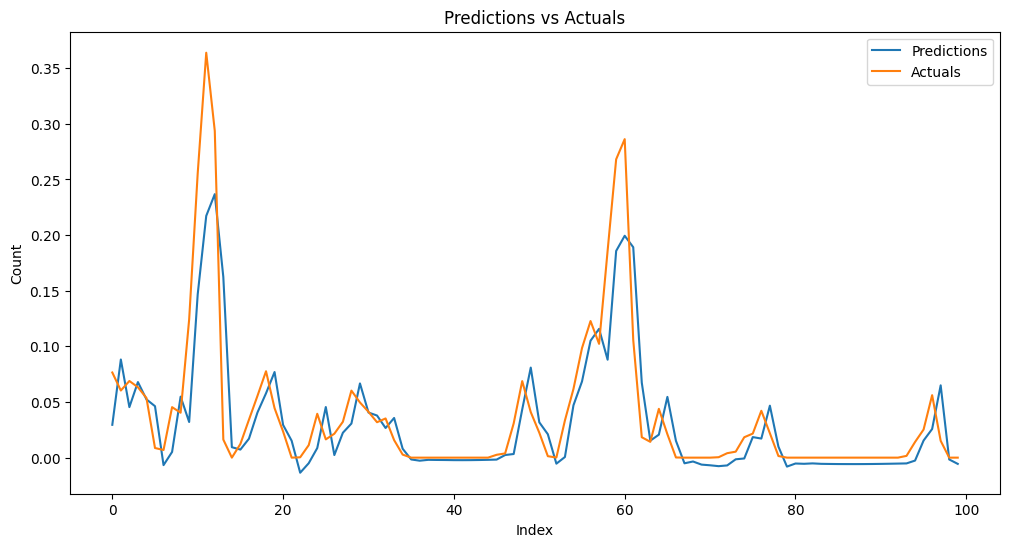

In [66]:
plot_predictions(model,X,Y)

In [43]:
!git clone https://github.com/zilliztech/cloud-vectordb-examples.git

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


fatal: destination path 'cloud-vectordb-examples' already exists and is not an empty directory.


In [ ]:
!pip3 install pymilvus==2.4.3

In [ ]:

uri="URL"
token = "TOKEN"
import configparser
import time
import random
from pymilvus import connections, utility
from pymilvus import Collection, DataType, FieldSchema, CollectionSchema


if __name__ == '__main__':
    # connect to milvus
    cfp = configparser.RawConfigParser()
    connections.connect("default",
                        uri="URL",
                        token="token")
    print(f"Connecting to DB: https://in03-5ddb10600a119ee.api.gcp-us-west1.zillizcloud.com")

    # Check if the collection exists
    collection_name = "book"
    check_collection = utility.has_collection(collection_name)
    if check_collection:
        drop_result = utility.drop_collection(collection_name)
    print("Success!")
    # create a collection with customized primary field: book_id_field
    dim = 64
    book_id_field = FieldSchema(name="id", dtype=DataType.INT64, is_primary=True, description="customized primary id")
    word_count_field = FieldSchema(name="Actual", dtype=DataType.INT64, description="word count")
    book_intro_field = FieldSchema(name="checkin_time", dtype=DataType.FLOAT_VECTOR, dim=dim)
    book_intro = FieldSchema(name="Predicted", dtype=DataType.FLOAT_VECTOR, dim=dim)
    book_ = FieldSchema(name="checkin_time_30_min_before", dtype=DataType.FLOAT_VECTOR, dim=dim)


    schema = CollectionSchema(fields=[book_id_field, word_count_field, book_intro_field,book_intro,book_],
                          auto_id=False,
                          description="my first collection")
    print(f"Creating example collection: {collection_name}")
    collection = Collection(name=collection_name, schema=schema)
    print(f"Schema: {schema}")
    print("Success!")

    # insert data with customized ids
    nb = 1000
    insert_rounds = 2
    start = 0           # first primary key id
    total_rt = 0        # total response time for inert
    print(f"Inserting {nb * insert_rounds} entities... ")
    for i in range(insert_rounds):
        book_ids = [i for i in range(start, start+nb)]
        word_counts = results_before_30min["Actual"]
        book_intros = results_before_30min["checkin_time"]
        ucuncu = results_before_30min["Predicted"]
        dorduncu = results_before_30min["checkin_time_30min_before"]
        
        entities = [book_ids, word_counts, book_intros,ucuncu,dorduncu]
        t0 = time.time()
        ins_resp = collection.insert(entities)
        ins_rt = time.time() - t0
        start += nb
        total_rt += ins_rt
    print(f"Succeed in {round(total_rt,6)} seconds!")
    # print(f"collection {collection_name} entities: {collection.num_entities}")

    # flush
    print("Flushing...")
    start_flush = time.time()
    collection.flush()
    end_flush = time.time()
    print(f"Succeed in {round(end_flush - start_flush, 4)} seconds!")
    # build index
    index_params = {"index_type": "AUTOINDEX", "metric_type": "L2", "params": {}}
    t0 = time.time()
    print("Building AutoIndex...")
    collection.create_index(field_name=book_intro_field.name, index_params=index_params)
    t1 = time.time()
    print(f"Succeed in {round(t1-t0, 4)} seconds!")

    # load collection
    t0 = time.time()
    print("Loading collection...")
    collection.load()
    t1 = time.time()
    print(f"Succeed in {round(t1-t0, 4)} seconds!")

    # search
    nq = 1
    search_params = {"metric_type": "L2",  "params": {"level": 2}}
    topk = 1
    for i in range(10):
        search_vec = [[random.random() for _ in range(dim)] for _ in range(nq)]
        print(f"Searching vector: {search_vec}")
        t0 = time.time()
        results = collection.search(search_vec,
                                anns_field=book_intro_field.name,
                                param=search_params,
                                limit=topk,
                                guarantee_timestamp=1)
        t1 = time.time()
        print(f"Result:{results}")
        print(f"search {i} latency: {round(t1-t0, 4)} seconds!")

    connections.disconnect("default")



In [66]:
dim = 64  # Vektör boyutu
collection_name = 'new'

# Vektör alanları için uygun boyutları ve türleri belirleyin
schema = CollectionSchema(
    fields=[
        FieldSchema(name="id", dtype=DataType.INT64, descrition="primary field", is_primary=True, auto_id=True),
        FieldSchema(name="checkin_time", dtype=DataType.VARCHAR, max_length=255),
        FieldSchema(name="checkin_time_before_30min", dtype=DataType.VARCHAR, max_length=255,dim=dim),
        FieldSchema(name="Actual", dtype=DataType.FLOAT),
        FieldSchema(name="Predicted", dtype=DataType.FLOAT),
        FieldSchema(name="vector", dtype=DataType.FLOAT_VECTOR,dim=2),

    ],
    description="my first collection"
)


collection = Collection(name=collection_name, schema=schema)


In [68]:
vectors = np.random.rand(21825, 2).tolist()
entities = [ checkin_times, checkin_times_30min_befores, actuals, predicteds,vectors]
collection.insert(entities)

(insert count: 21825, delete count: 0, upsert count: 0, timestamp: 451520929757396995, success count: 21825, err count: 0, cost: 0)

In [77]:
print("Flushing...")
start_flush = time.time()
collection.flush()
end_flush = time.time()
print(f"Succeeded in {round(end_flush - start_flush, 4)} seconds!")

# Index parametrelerini belirleme
index_params = {"index_type": "AUTOINDEX", "metric_type": "L2", "params": {}}

# Endeks oluşturma
t0 = time.time()
print("Building AutoIndex...")
collection.create_index(field_name="vector", index_params=index_params)
t1 = time.time()
print(f"Succeeded in {round(t1 - t0, 4)} seconds!")

# Koleksiyonu yükleme
t0 = time.time()
print("Loading collection...")
collection.load()
t1 = time.time()
print(f"Succeeded in {round(t1 - t0, 4)} seconds!")

# Arama parametrelerini belirleme
search_params = {"metric_type": "L2", "params": {"level": 2}}
topk = 1
nq = 1  # Aranacak vektör sayısı
dim = 2
# Arama yapma
for i in range(10):
    search_vec = [[random.random() for _ in range(dim)] for _ in range(nq)]
    print(f"Searching vector: {search_vec}")
    t0 = time.time()
    results = collection.search(
        search_vec,
        anns_field="vector",
        param=search_params,
        limit=topk,
        guarantee_timestamp=1
    )
    t1 = time.time()
    print(f"Result: {results}")
    print(f"Search {i} latency: {round(t1 - t0, 4)} seconds!")

# Bağlantıyı kapatma
connections.disconnect("default")

Flushing...
Succeeded in 0.9565 seconds!
Building AutoIndex...
Succeeded in 1.1055 seconds!
Loading collection...
Succeeded in 0.308 seconds!
Searching vector: [[0.689963259803163, 0.8448205011826893]]
Result: data: ["['id: 451392113231110285, distance: 0.08843907713890076, entity: {}']"] , cost: 0
Search 0 latency: 0.1497 seconds!
Searching vector: [[0.10551485965391283, 0.39060432842251747]]
Result: data: ["['id: 451392113231110202, distance: 0.002912897849455476, entity: {}']"] , cost: 0
Search 1 latency: 0.1511 seconds!
Searching vector: [[0.27978745968868046, 0.7803349538553479]]
Result: data: ["['id: 451392113231104661, distance: 0.0022850309032946825, entity: {}']"] , cost: 0
Search 2 latency: 0.151 seconds!
Searching vector: [[0.41213961771799046, 0.1155740715947371]]
Result: data: ["['id: 451392113231096153, distance: 0.01782660186290741, entity: {}']"] , cost: 0
Search 3 latency: 0.152 seconds!
Searching vector: [[0.609880516508328, 0.22372213239512084]]
Result: data: ["['id:

In [26]:
!pip install flask

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [ ]:
from flask import Flask, request, jsonify, render_template

app = Flask(__name__)

model = tf.keras.models.load_model('/kaggle/working/flight_model.h5')
data_store = []

@app.route('/load_data', methods=['POST'])

def load_data():
    
    data_store = df.to_dict('records')
    return jsonify({"message": "Data loaded successfully"}), 200

@app.route('/predict', methods=['POST'])

def predict():
    query_time = request.get_json().get('checkin_time')
    results = [entry for entry in data_store if entry['checkin_time'] == query_time]
    
    if not results:
        return jsonify({"message": "No data found for the given checkin_time"}), 404
    
    predictions = []
    for result in results:
        actual = result['Actual']
        # Modelden tahmin yapın
        input_data = np.array([[actual]])  # Modelin beklediği formatta veri oluşturun
        predicted = model.predict(input_data)
        predictions.append({"actual": actual, "predicted": predicted[0][0]})
    
    return jsonify({"predictions": predictions}), 200

if __name__ == '__main__':
    app.run(debug=True, port=5001)

In [57]:
print(extracted.index.min(), extracted.index.max())

2022-11-25 03:37:34 2024-02-23 21:50:11


In [56]:
utility.get_server_version()

'v2.3.5-lite'